In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
# reply = requests.get('https://gitlab.com/data.europa.eu/data-provider-repository/-/raw/master/dg-eac/2021.05.11%20KA3%20mobilities%20eligible%20finalised%20started%20in%202014-2019.csv?inline=false')
reply = requests.get('https://gitlab.com/data.europa.eu/data-provider-repository/-/raw/master/dg-eac/2021.05.11%20KA1%20mobilities%20eligible%20finalised%20started%20in%202018.csv?inline=false')
reply.encoding = 'utf-8'

In [3]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False, header=0)
for i, name in enumerate(df.columns):
    print(i, name)
df.drop(columns=['GroupLeader', 'Sending Organisation Erasmus Code', 'Receiving Organisation Erasmus Code'], inplace=True)
c_df = df.copy() # we will use it for later (country network)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 GroupLeader
14 Participant Age
15 Sending Country Code
16 Sending City
17 Sending Organization
18 Sending Organisation Erasmus Code
19 Receiving Country Code
20 Receiving City
21 Receiving Organization
22 Receiving Organisation Erasmus Code
23 Participants


In [4]:
pd.options.display.max_columns=21
display(df)

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,Participant Profile,Special Needs,Fewer Opportunities,Participant Age,Sending Country Code,Sending City,Sending Organization,Receiving Country Code,Receiving City,Receiving Organization,Participants
0,2015-3-PT02-KA105-002866,2018-2019,2018-01,2018-05,146.0,European Voluntary Service - Programme Countries,? Unknown ?,PT,??? - ? Unknown ?,Male,Learner,No,No,22,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
1,2015-3-PT02-KA105-002866,2018-2019,2018-01,2018-05,146.0,European Voluntary Service - Programme Countries,? Unknown ?,PT,??? - ? Unknown ?,Male,Learner,No,Yes,26,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
2,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,27,AT,Wien,Neue Mittelschule Glasergasse,SI,Portoro�,Osnovna sola Lucija,1
3,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,28,AT,Vienna,NMSI & JHS Konstanziagasse 50,SI,Portoro�,Osnovna sola Lucija,1
4,2016-1-AT01-KA101-016290,2018-2019,2018-01,2018-01,6.0,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ? Unknown ?,Female,Staff,No,No,35,AT,Wien,GTKMS/GTNMS Anton-Sattler-Gasse,SI,Portoro�,Osnovna sola Lucija,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
690326,2018-2-UK01-KA125-048625,2018-2019,2018-09,2019-07,319.0,Individual Volunteering Activities,? Unknown ?,ES,??? - ? Unknown ?,Female,Learner,No,No,21,ES,Madrid,Asociación para la integración y Progreso de l...,UK,Stackpole,The National Trust for Places of Historic Inte...,1
690327,2018-2-UK01-KA125-048626,2018-2019,2018-10,2019-03,137.0,Individual Volunteering Activities,? Unknown ?,ES,??? - ? Unknown ?,Male,Learner,No,No,27,ES,BARCELONA,COORDINADORA D'ORGANITZADORS DE CAMPS DE TREBA...,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
690328,2018-2-UK01-KA125-048626,2018-2019,2018-11,2019-04,170.0,Individual Volunteering Activities,? Unknown ?,CZ,??? - ? Unknown ?,Female,Learner,No,No,24,CZ,PRAHA,INEX - SDRUZENI DOBROVOLNYCH AKTIVIT Z S,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
690329,2018-2-UK01-KA125-048626,2018-2019,2018-11,2019-10,351.0,Individual Volunteering Activities,? Unknown ?,FR,??? - ? Unknown ?,Male,Learner,No,No,23,FR,PARIS,SOLIDARITES JEUNESSES MCP,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1


In [5]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student')]
mobility_df = mobility_df[~mobility_df['Activity (mob)'].str.contains('traineeship')]
# consideriamo solo l'anno accademico 2018/2019 o 2017/2018?
# i numeri cambiano parecchio di anno in anno, è normale?
#mobility_df = mobility_df[mobility_df['Academic Year'].str.contains('19')]
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20, 5, 15, 18))]]
print((mobility_df['Receiving Organization'].nunique()))
print((mobility_df['Sending Organization'].nunique()))

3789
4306


In [6]:
for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()

print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))
mobility_df

Number of Receiving Universities:  3696
Number of Sending Universities:  4227


,Sending Organization,Receiving Organization,Participants,Activity (mob),Sending City,Receiving City
174,VORARLBERGER LANDESKONSERVATORIUM,LUNDS UNIVERSITET,1,Student mobility for studies between Programme...,FELDKIRCH,LUND
195,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1,Student mobility for Studies To/From Partner C...,LEOBEN,Saint-Petersburg
202,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
203,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
204,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...,DNIPROPETROVSK,LEOBEN
...,...,...,...,...,...,...
668733,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668734,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668735,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI
668736,UNIVERSITY OF GLASGOW,ILIA STATE UNIVERSITY,1,Student mobility for Studies To/From Partner C...,GLASGOW,TBILISI


In [7]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [8]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

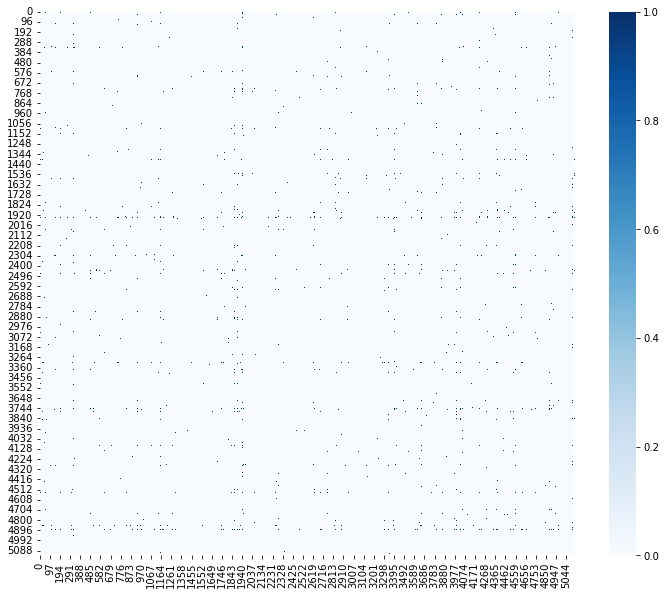

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [10]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
uni_cities = mobility_df.copy()
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

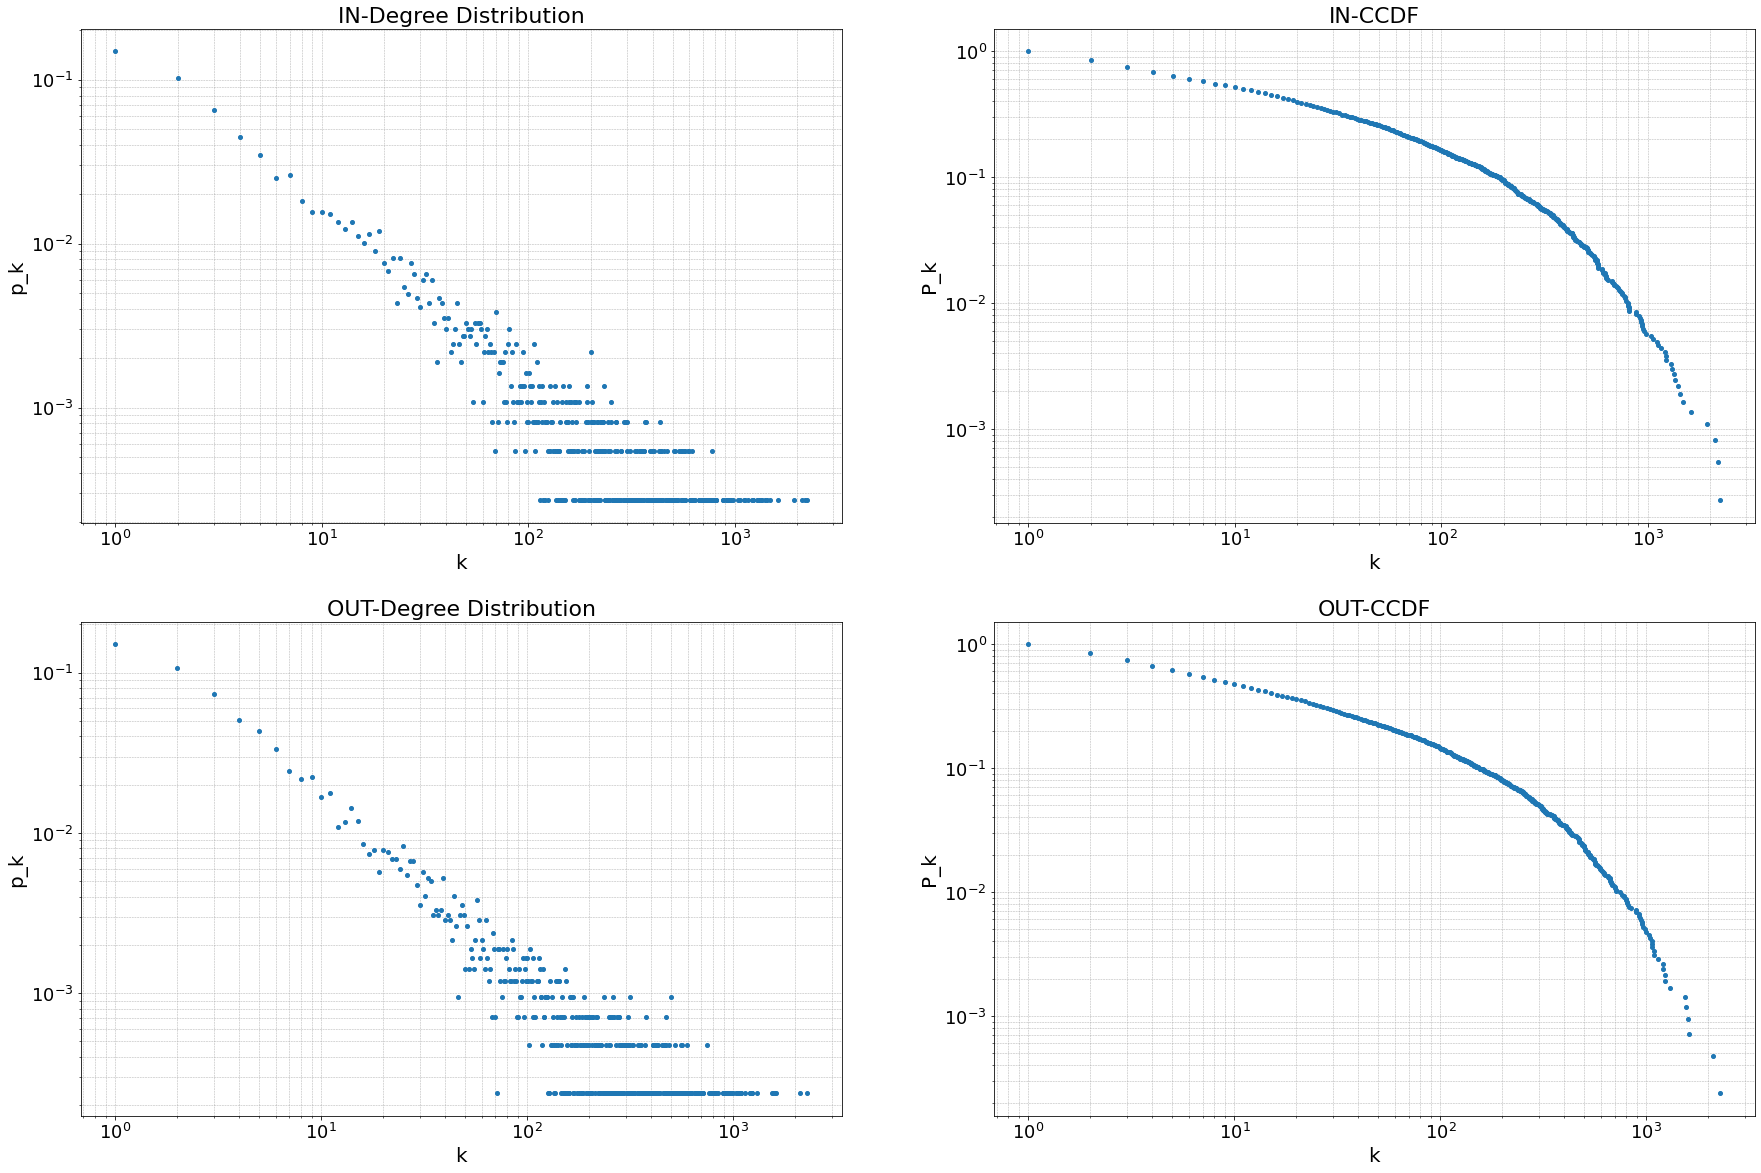

Top 10 for in degree


,Nodes,in degree
724,UNIVERSITAT DE VALENCIA,2238
51,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2179
1934,UNIVERSIDADE DE LISBOA,2118
4136,UNIVERSIDAD DE GRANADA,1931
2614,UNIVERSIDAD COMPLUTENSE DE MADRID,1612
4860,UNIVERZA V LJUBLJANI,1481
320,UNIVERSITAT POLITECNICA DE VALENCIA,1434
675,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1405
3898,UNIVERSIDAD DE SEVILLA,1350
3489,KATHOLIEKE UNIVERSITEIT LEUVEN,1341


Top 10 for out degree


,Nodes,out degree
51,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2280
4136,UNIVERSIDAD DE GRANADA,2114
724,UNIVERSITAT DE VALENCIA,1604
2614,UNIVERSIDAD COMPLUTENSE DE MADRID,1590
4565,UNIVERSITA DEGLI STUDI DI PADOVA,1563
1974,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1544
1267,UNIVERSITA DEGLI STUDI DI TORINO,1299
1934,UNIVERSIDADE DE LISBOA,1228
3489,KATHOLIEKE UNIVERSITEIT LEUVEN,1225
4082,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1203


In [11]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [12]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 100
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [13]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

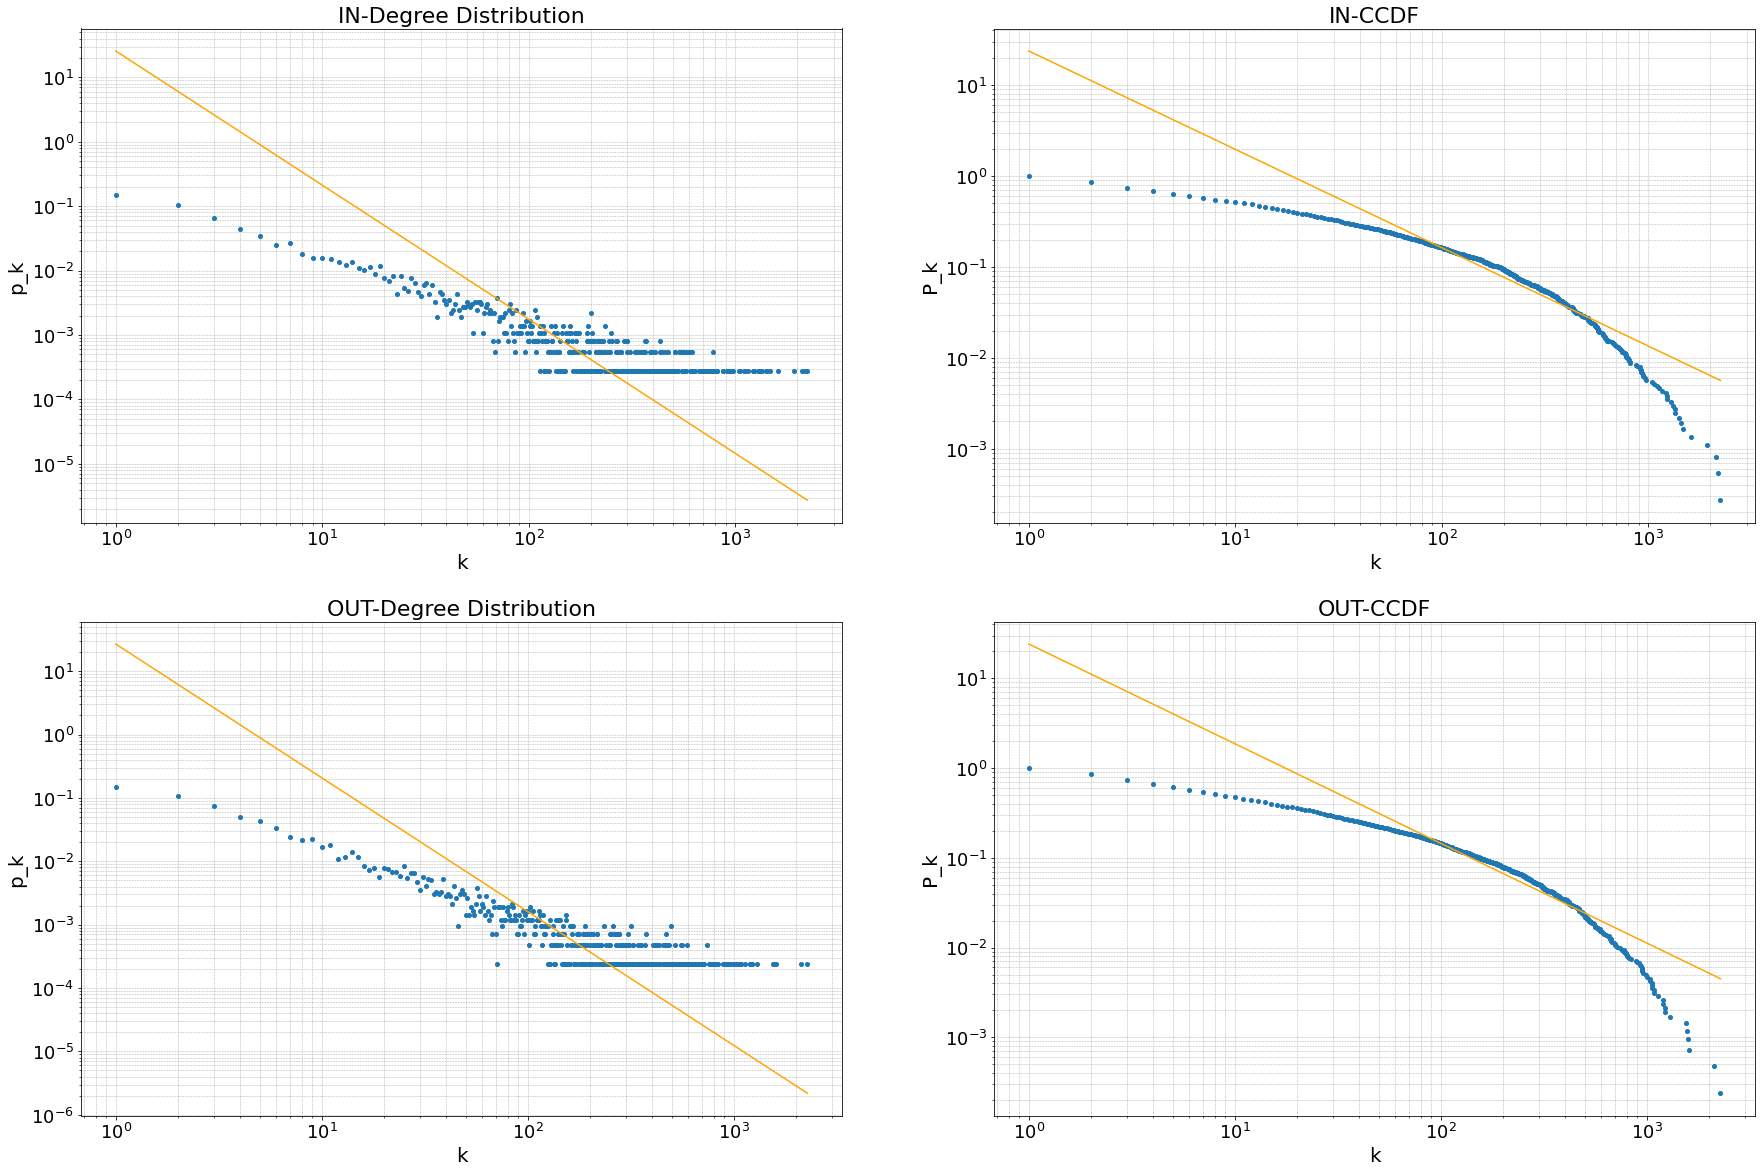

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    ax.loglog(x, p, color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [15]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )

mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

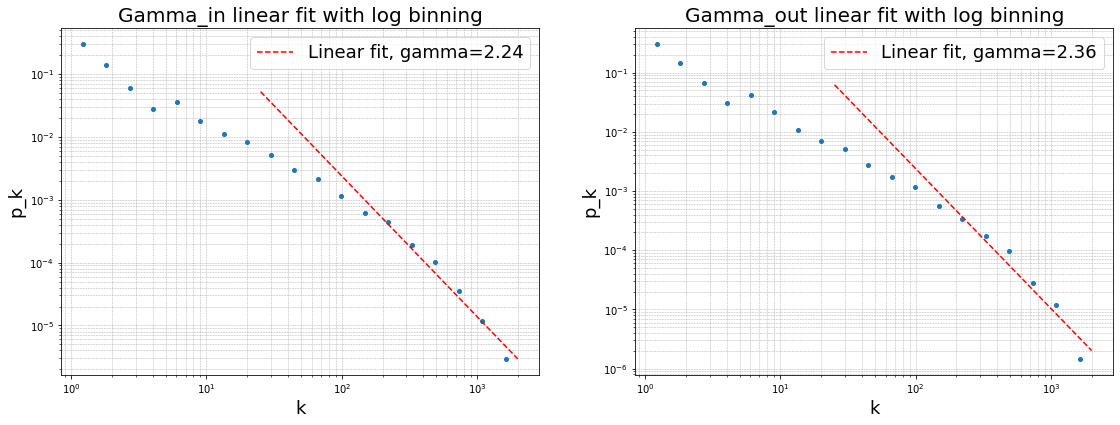

In [16]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

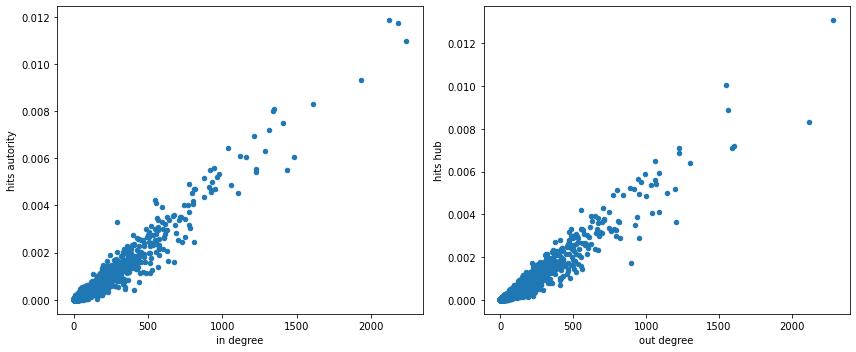

Top 10 for hits hub


,Nodes,hits hub
51,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013068
1974,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.010048
4565,UNIVERSITA DEGLI STUDI DI PADOVA,0.008881
4136,UNIVERSIDAD DE GRANADA,0.008339
724,UNIVERSITAT DE VALENCIA,0.007203
1934,UNIVERSIDADE DE LISBOA,0.007114
2614,UNIVERSIDAD COMPLUTENSE DE MADRID,0.007107
3489,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006883
4937,TECHNISCHE UNIVERSITAET MUENCHEN,0.006487
1267,UNIVERSITA DEGLI STUDI DI TORINO,0.006378


Top 10 for hits autority


,Nodes,hits autority
1934,UNIVERSIDADE DE LISBOA,0.011846
51,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011721
724,UNIVERSITAT DE VALENCIA,0.010979
4136,UNIVERSIDAD DE GRANADA,0.009306
2614,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008310
3898,UNIVERSIDAD DE SEVILLA,0.008109
3489,KATHOLIEKE UNIVERSITEIT LEUVEN,0.008007
675,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.007508
3287,UNIVERZITA KARLOVA,0.007196
3889,UNIVERSITAT DE BARCELONA,0.006963


In [17]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

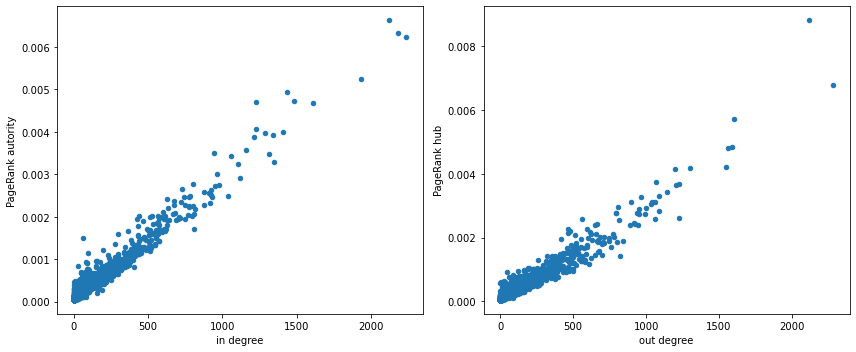

Top 10 for PageRank hub


,Nodes,PageRank hub
4136,UNIVERSIDAD DE GRANADA,0.008810
51,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006786
724,UNIVERSITAT DE VALENCIA,0.005716
2614,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004823
4565,UNIVERSITA DEGLI STUDI DI PADOVA,0.004807
1974,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004214
1267,UNIVERSITA DEGLI STUDI DI TORINO,0.004182
1509,UNIVERSIDAD POLITECNICA DE MADRID,0.004139
4860,UNIVERZA V LJUBLJANI,0.003745
1934,UNIVERSIDADE DE LISBOA,0.003693


Top 10 for PageRank autority


,Nodes,PageRank autority
1934,UNIVERSIDADE DE LISBOA,0.006626
51,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006335
724,UNIVERSITAT DE VALENCIA,0.006226
4136,UNIVERSIDAD DE GRANADA,0.005244
320,UNIVERSITAT POLITECNICA DE VALENCIA,0.004949
4860,UNIVERZA V LJUBLJANI,0.004723
1481,POLITECNICO DI MILANO,0.004714
2614,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004670
4565,UNIVERSITA DEGLI STUDI DI PADOVA,0.004074
675,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.003990


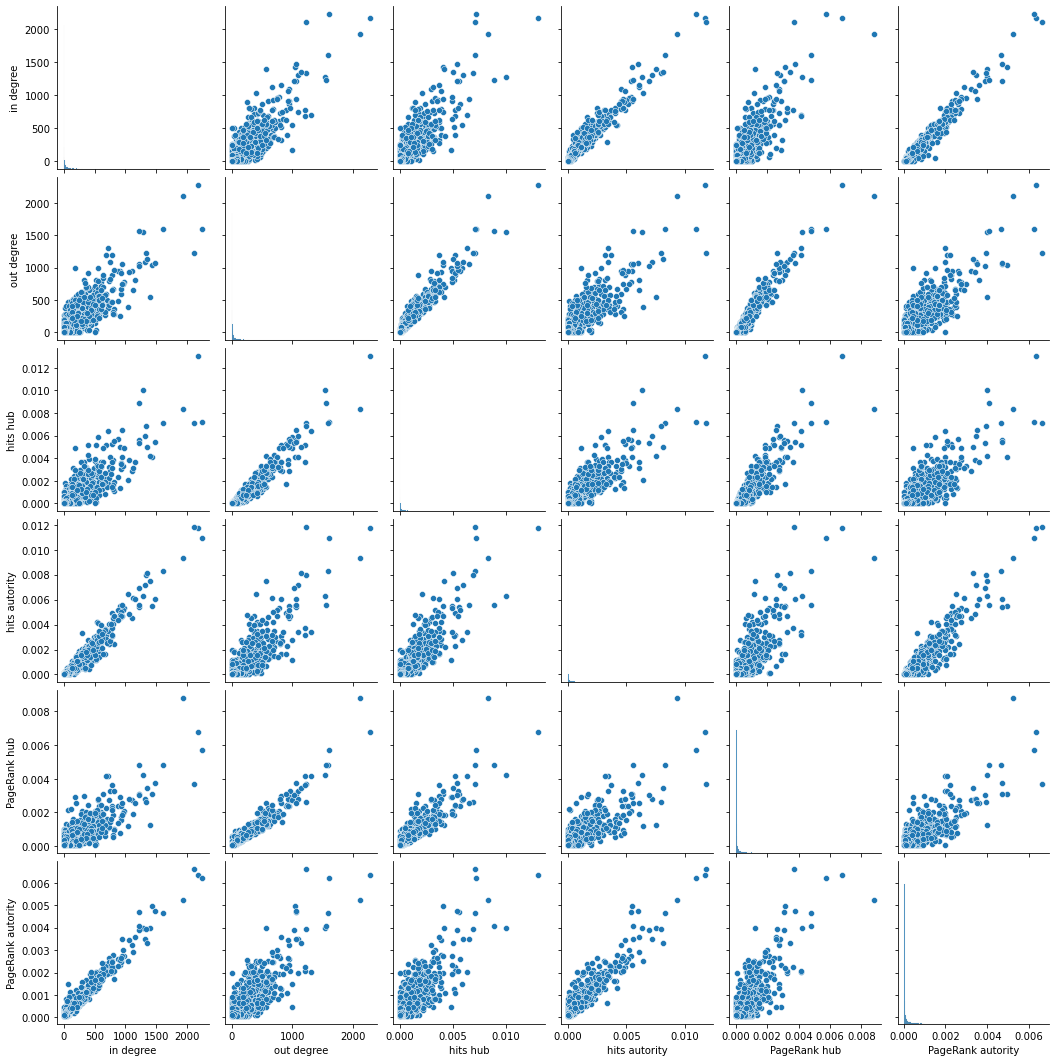

In [18]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

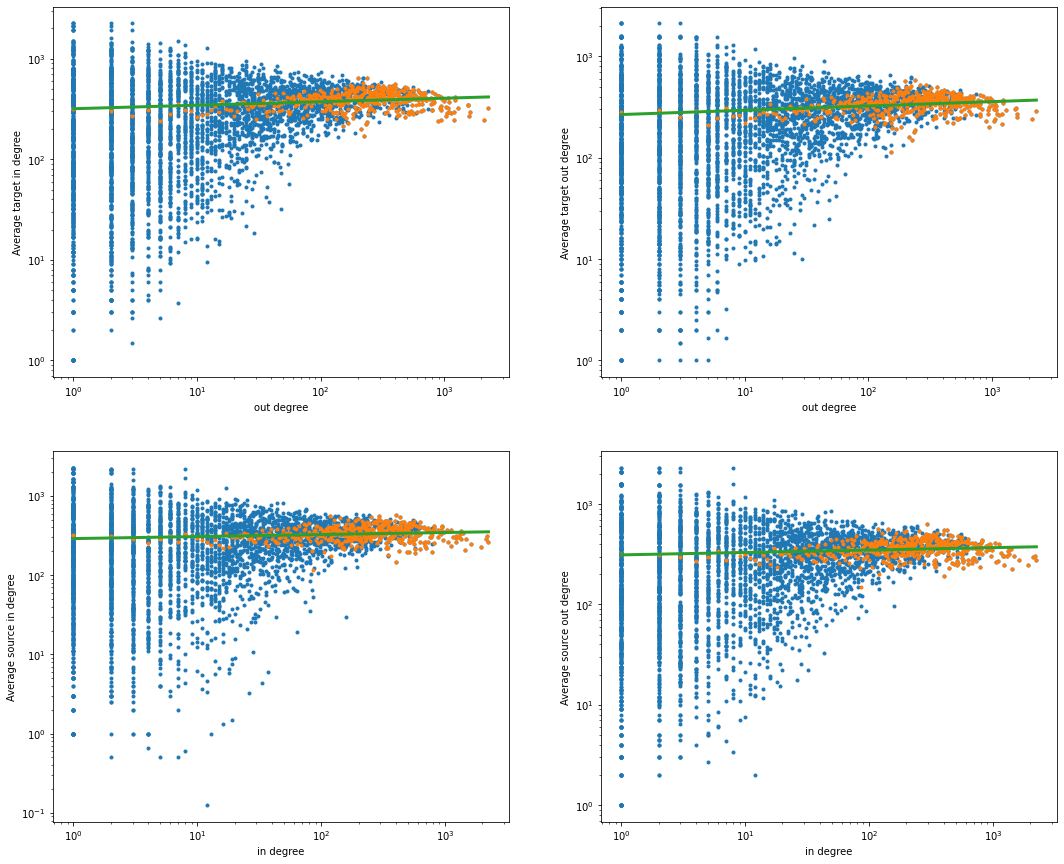

(0.034832263162413606,
 0.04243076951818892,
 0.02551010144932137,
 0.02403733513504581)

In [19]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)

### Robustness

In [20]:
#attack: removing hubs first
nodes_byhub = scores.sort_values('PageRank hub', ascending=False)['NodeID']
indices = list(nodes_byhub)
uni_df = mobility_df.copy()
GC_frac_a = [1]
for node in indices:
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
    temp_serie = uni_df.groupby(['sourceID', 'targetID']).sum()
    row = np.array(temp_serie.index.get_level_values(1).tolist())
    col = np.array(temp_serie.index.get_level_values(0).tolist())
    val = temp_serie.values
    temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
    GC_frac_a.append(ns.fraction_in_giant(temp_adj))


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\tomma\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\tomma\AppData\Local\Temp/ipykernel_15984/1130422312.py", line 7, in <module>
    uni_df = uni_df.loc[(uni_df['sourceID'] != node) & (uni_df['targetID'] != node)]
  File "C:\Users\tomma\anaconda3\lib\site-packages\pandas\core\ops\common.py", line 69, in new_method
    return method(self, other)
  File "C:\Users\tomma\anaconda3\lib\site-packages\pandas\core\arraylike.py", line 36, in __ne__
    return self._cmp_method(other, operator.ne)
  File "C:\Users\tomma\anaconda3\lib\site-packages\pandas\core\series.py", line 5502, in _cmp_method
    res_values = ops.comparison_op(lvalues, rvalues, op)
  File "C:\Users\tomma\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py", line 287, in comparison_op
    res_values = _na_arithmetic_op(lvalues, rvalues, op, is_cmp=True)
  File "

TypeError: object of type 'NoneType' has no len()

In [ ]:
#random node removal
import random
#10 by 10, with average over 10 trials each time
intervals = list(range(10, len(nodes_byhub+1), 10))
uni_df = mobility_df.copy()
GC_frac_r = [1]
for i in intervals:
    i_GC_frac = []
    for j in range(10):
        removed = random.sample(indices, i)
        temp_df = uni_df.loc[~(uni_df['sourceID'].isin(removed) | (uni_df['targetID'].isin(removed)))]
        temp_serie = temp_df.groupby(['sourceID', 'targetID']).sum()
        row = np.array(temp_serie.index.get_level_values(1).tolist())
        col = np.array(temp_serie.index.get_level_values(0).tolist())
        val = temp_serie.values
        temp_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))
        i_GC_frac.append(ns.fraction_in_giant(temp_adj))
    GC_frac_r.append(sum(i_GC_frac)/10)

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.plot([i/len(nodes_byhub) for i in range(len(nodes_byhub)+1)], GC_frac_a, label='Targeted attack')
plt.plot([0]+[i/(len(intervals)*10) for i in intervals], GC_frac_r, 'r', label='Random node removal')
plt.plot([0,1], [1,0], 'g', label='linear reference')
plt.xlabel('Fraction of nodes in the giant component', size=14)
plt.ylabel('Fraction of removed nodes', size=14)
plt.title('Robustness', size=20)
plt.legend(fontsize=16)
plt.show()

## Communities

In [ ]:
import networkx as nx

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()
node_comm.drop(columns=['NodeID'], inplace=True)

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])
    
scores['Community'] = node_comm['Community']
# 52 communities. Choose if it makes sense to reduce the number of them 

## Geographical heatmap

In [21]:
temp_df = uni_cities[['target', 'Receiving City']].copy()
temp_df.rename({'target':'source', 'Receiving City':'Sending City'},axis=1, inplace=True)
cities_uni = pd.concat([uni_cities[['source', 'Sending City']], temp_df]).drop_duplicates().reset_index(drop=True)

for index in range(cities_uni.shape[0]):
    city = cities_uni.iat[index,1]
    if city != city.upper():
        cities_uni.iat[index,1] = city.upper()
cities_uni = cities_uni.drop_duplicates().reset_index(drop=True)
cities_uni = cities_uni.drop_duplicates(subset='source').reset_index(drop=True)

# assigning cities to each university in scores
cities_list = []
for u in scores['Nodes']:
    cities_list.append(list(cities_uni.loc[cities_uni['source'] == u, 'Sending City'])[0])

scores_cities = scores.copy()
scores_cities['City'] = cities_list

scores_cities

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,City
0,AKADEMIA WYCHOWANIA FIZYCZNEGO JOZEFA PILSUDSK...,0,114,98,0,5.039560e-04,3.412100e-04,0,0.000319,0.000392,WARSZAWA
1,VESALIUS COLLEGE,1,3,0,1,-0.000000e+00,1.402949e-06,1,0.000045,0.000055,BRUSSELS
2,COLLEGE OF TOURISM AND HOTEL MANAGEMENT,2,1,0,2,-0.000000e+00,2.291718e-08,2,0.000045,0.000065,NICOSIA
3,VENTSPILS AUGSTSKOLA,3,26,25,3,3.579671e-05,1.620383e-05,3,0.000169,0.000092,VENTSPILS
4,UNIVERSITE PARIS III SORBONNE NOUVELLE,4,289,253,4,1.382410e-03,1.665670e-03,4,0.000769,0.000803,PARIS
...,...,...,...,...,...,...,...,...,...,...,...
5094,ECOLE NATIONALE SUPÉRIEURE DE TECHNOLOGIE ENST,5094,0,6,5094,1.049633e-06,-0.000000e+00,5094,0.000073,0.000043,ALGIERS
5095,UNIVERSITAT VECHTA,5095,1,0,5095,-0.000000e+00,2.026796e-06,5095,0.000045,0.000044,VECHTA
5096,ECOLE NATIONALE DE L AVIATION CIVILE,5096,24,27,5096,1.229567e-04,8.576477e-05,5096,0.000080,0.000141,TOULOUSE
5097,HAUTE ECOLE BRUXELLES-BRABANT (HE2B),5097,11,13,5097,9.077139e-06,7.891221e-05,5097,0.000113,0.000067,BRUXELLES


In [22]:
city_coord = pd.read_csv('worldcities.csv', encoding='utf8')
city_coord.drop(columns=['capital', 'population', 'id', 'iso3', 'country'], inplace=True)
for index in range(city_coord.shape[0]):
    city = city_coord.iat[index,0]
    if city != city.upper():
        city_coord.iat[index,0] = city.upper()
city_coord = city_coord.drop_duplicates().reset_index(drop=True)
scores_cities = pd.merge(left=scores_cities, right=city_coord, how='left', left_on='City', right_on='city')
scores_cities.dropna(subset=['city'], inplace=True)
scores_cities = scores_cities.drop_duplicates(subset='Nodes').reset_index(drop=True)
scores_cities

# some cities are missing like Milano, Torino, Madrid (these are also pretty much important)

,Nodes,NodeID_x,in degree,out degree,NodeID_y,hits hub,hits autority,NodeID,PageRank hub,PageRank autority,City,city,city_ascii,lat,lng,iso2,admin_name
0,VESALIUS COLLEGE,1,3,0,1,-0.000000e+00,1.402949e-06,1,0.000045,0.000055,BRUSSELS,BRUSSELS,Brussels,50.8333,4.3333,BE,Brussels-Capital Region
1,COLLEGE OF TOURISM AND HOTEL MANAGEMENT,2,1,0,2,-0.000000e+00,2.291718e-08,2,0.000045,0.000065,NICOSIA,NICOSIA,Nicosia,35.1725,33.3650,CY,Lefkosía
2,VENTSPILS AUGSTSKOLA,3,26,25,3,3.579671e-05,1.620383e-05,3,0.000169,0.000092,VENTSPILS,VENTSPILS,Ventspils,57.3897,21.5644,LV,Ventspils
3,UNIVERSITE PARIS III SORBONNE NOUVELLE,4,289,253,4,1.382410e-03,1.665670e-03,4,0.000769,0.000803,PARIS,PARIS,Paris,48.8566,2.3522,FR,Île-de-France
4,FONDATION ECAM,5,4,13,5,4.557276e-05,2.416922e-05,5,0.000087,0.000051,LYON,LYON,Lyon,45.7600,4.8400,FR,Auvergne-Rhône-Alpes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3519,MICHELLE CADE,5093,1,0,5093,-0.000000e+00,6.124379e-07,5093,0.000045,0.000046,DETROIT,DETROIT,Detroit,42.3834,-83.1024,US,Michigan
3520,ECOLE NATIONALE SUPÉRIEURE DE TECHNOLOGIE ENST,5094,0,6,5094,1.049633e-06,-0.000000e+00,5094,0.000073,0.000043,ALGIERS,ALGIERS,Algiers,36.7764,3.0586,DZ,Alger
3521,UNIVERSITAT VECHTA,5095,1,0,5095,-0.000000e+00,2.026796e-06,5095,0.000045,0.000044,VECHTA,VECHTA,Vechta,52.7306,8.2886,DE,Lower Saxony
3522,ECOLE NATIONALE DE L AVIATION CIVILE,5096,24,27,5096,1.229567e-04,8.576477e-05,5096,0.000080,0.000141,TOULOUSE,TOULOUSE,Toulouse,43.6045,1.4440,FR,Occitanie


Importing geographic data also for countries

In [25]:
import geopandas as gpd
import pycountry as pc #library used for translating country codes from iso3 to iso2 standard

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# merge geometries with our dataframe
geo_scores = pd.merge(left=scores_cities, right=geo_df[['iso2_code', 'geometry']], how='left', 
                      left_on='iso2', right_on='iso2_code')
geo_scores = geo_scores[['Nodes', 'PageRank hub', 'PageRank autority', 'City', 'lat', 'lng', 'iso2', 'geometry']]

divide universities by their country community

In [26]:
import networkx as nx

### 1 create the network of countries only
country_df = c_df[c_df[c_df.columns[10]]=='Learner']
country_df = country_df.loc[:, c_df.columns[np.array((14, 17, 20))]]
country_df.dropna(how='any', inplace=True)

# nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
c_nodes = np.array(list(set.union(set(country_df.loc[:, country_df.columns[0]]), set(country_df.loc[:, country_df.columns[1]]))))
country_df.dropna(how='any', inplace=True)

c_node_position = {}
for i, name in enumerate(c_nodes):
    c_node_position[name] = i
country_nodes= pd.DataFrame({'Nodes': c_nodes})
country_df['SendId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Sending Country Code']))))
country_df['RecId'] = (np.array(list(map(lambda x: c_node_position[x], country_df['Receiving Country Code']))))
# Adjacency matrix
country_serie = country_df.groupby(['SendId', 'RecId']).sum()
row = np.array(country_serie.index.get_level_values(1).tolist())
col = np.array(country_serie.index.get_level_values(0).tolist())
val = country_serie.values
c_adj_matrix = sparse.csr_matrix((val.flatten(), (row, col)), shape=(c_nodes.size, c_nodes.size))

### 2 countries community
G_country = nx.convert_matrix.from_scipy_sparse_matrix(c_adj_matrix)
p_c = nx.algorithms.community.modularity_max.greedy_modularity_communities(G_country)
country_comm = country_nodes.copy()

country_comm['Community']=np.zeros(len(country_comm.index),dtype='int8')
for i, set in enumerate(p_c):
    for element in set:
        country_comm.iat[element, 1]=i
for i, set in enumerate(p_c):
    display(country_comm[country_comm['Community']==i])

geo_scores = pd.merge(left=geo_scores, right=country_comm, how='left', left_on='iso2', right_on='Nodes')

,Nodes,Community
2,NZ,0
5,PY,0
8,NP,0
11,GH,0
13,ES,0
...,...,...
127,TM,0
129,AU,0
136,JP,0
140,ML,0


,Nodes,Community
0,MK,1
3,BG,1
4,XK,1
9,RW,1
10,IE,1
...,...,...
137,FJ,1
141,RS,1
142,MA,1
144,DK,1


,Nodes,Community
1,PG,2
7,UZ,2
16,AR,2
17,ZM,2
30,TJ,2
...,...,...
128,DZ,2
130,PE,2
134,NG,2
138,US,2


,Nodes,Community
21,CN,3
25,TZ,3
27,LK,3
40,IN,3
56,NO,3
57,BO,3
83,JM,3
84,SE,3
121,LA,3


,Nodes,Community
6,MO,4
37,BT,4
50,LB,4
97,PT,4
100,TN,4
103,HU,4
133,TL,4
139,JO,4


,Nodes,Community
18,NI,5
35,CM,5
45,BE,5
53,CH,5
71,LI,5
132,CD,5


In [31]:
# focus on european countries
eu_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']

def replace_iso3166(alpha):
    try:
        return pc.countries.get(name=alpha).alpha_2
    except:
        return alpha
    
eu_countries_iso2 = list(map(lambda x: replace_iso3166(x), eu_countries))

geo_scores = geo_scores[geo_scores['iso2'].isin(eu_countries_iso2)]

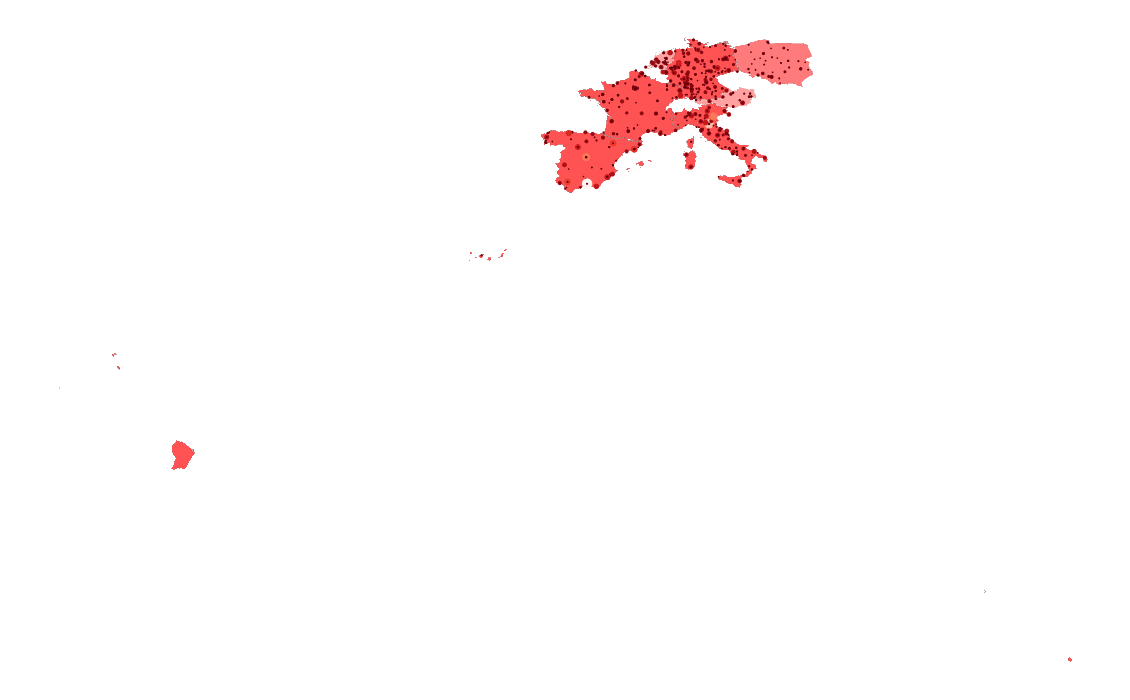

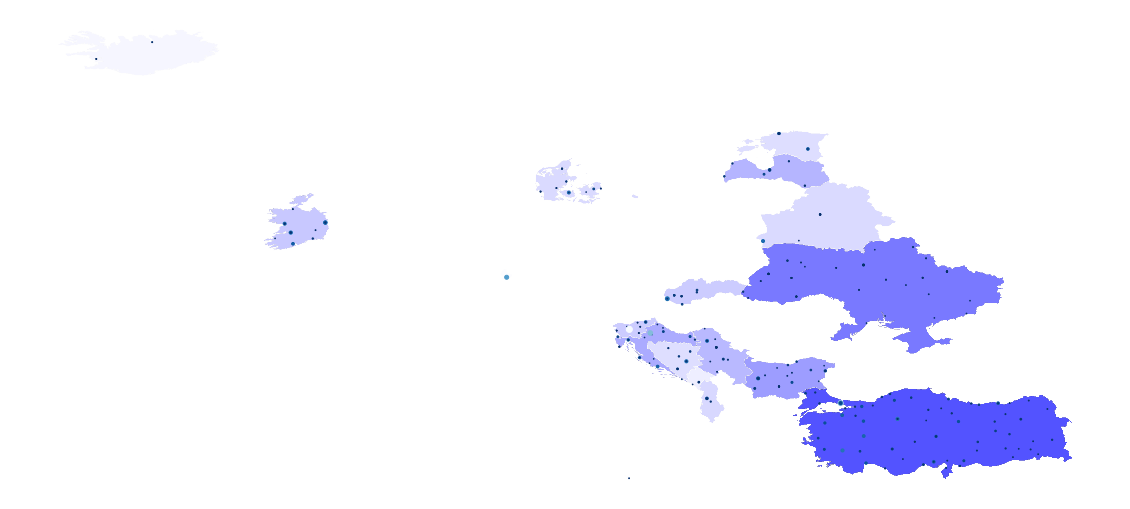

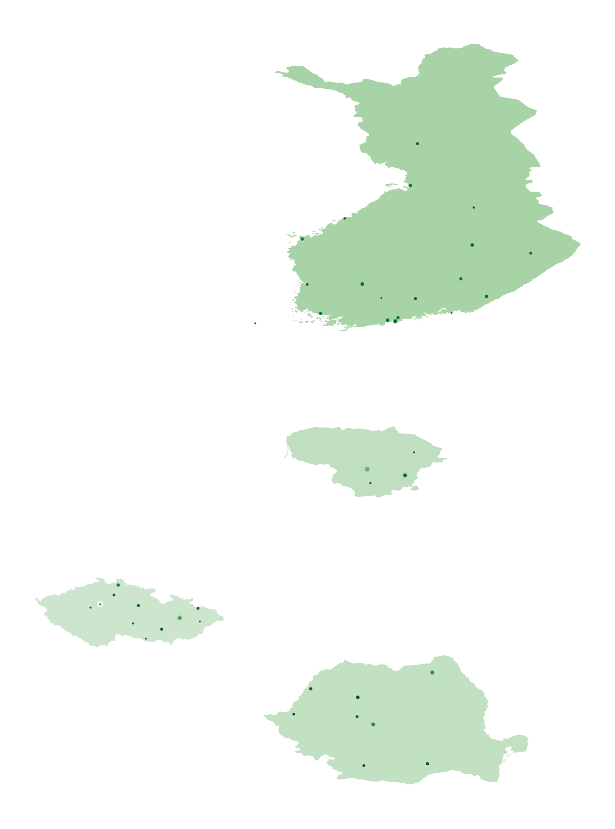

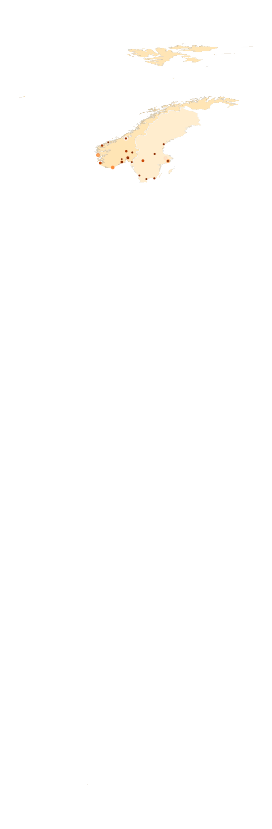

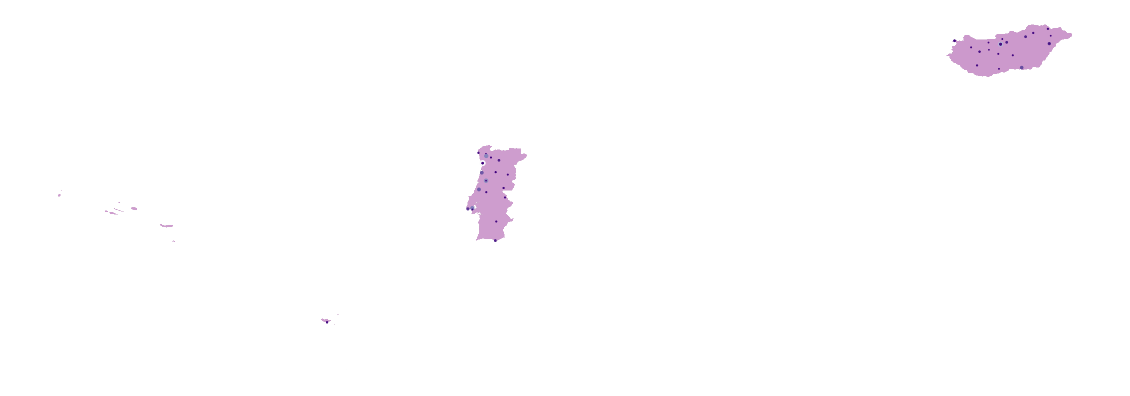

In [73]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
cmaps = ['Reds_r', 'Blues_r', 'Greens_r', 'Oranges_r', 'Purples_r']

for c in range(5):
    fig, ax = plt.subplots(figsize=(20,15))
    temp_df = geo_scores[geo_scores['Community'] == c].copy()
    temp_df = gpd.GeoDataFrame(temp_df, geometry = 'geometry')
    temp_df.plot(ax=ax, edgecolor='0.5', linewidth=0.3, color=colors[c], alpha=0.01)
    ax.scatter(x=temp_df['lng'], y=temp_df['lat'], s=temp_df['PageRank hub']*10**4, c=temp_df['PageRank hub'],
                  cmap=cmaps[c])
    ax.axis('off')
    
# try to merge everything in a single map